In [1]:
using DataFrames, CSV

In [2]:
df = CSV.read("random_30000_test.flagged.csv");

In [3]:
α = df.ra
δ = df.dec
r = hcat((cos.(α) .* cos.(δ)),
             (sin.(α) .* cos.(δ)),
             (sin.(δ)))
A = [0.0548755604162154 +0.4941094278755837 -0.8676661490190047
              -0.8734370902348850 -0.4448296299600112 -0.1980763734312015
              -0.4838350155487132 +0.7469822444972189 +0.4559837761750669]
rGal = r * A
X = rGal[:, 1]
Y = rGal[:, 2]
Z = rGal[:, 3]
;

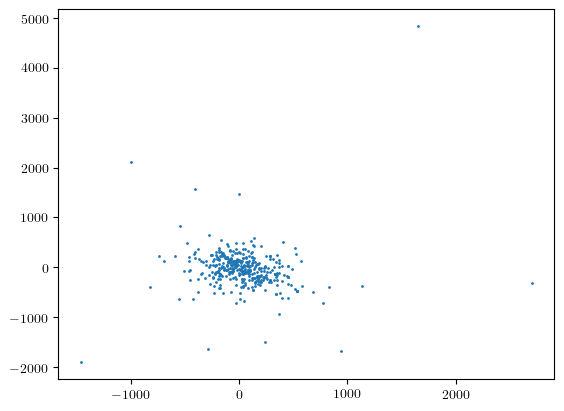

PyObject <matplotlib.collections.PathCollection object at 0x13f4914e0>

In [4]:
using PyPlot
mask = (.! (ismissing.(X) .| ismissing.(Y))) .& (df.logg .> 3)
plt.scatter(X[mask] .* df.rest[mask], Y[mask].* df.rest[mask], s=1)